In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset

import numpy as np

import math

import time

import dataloader
import training_fun

import HydroErr

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEQ_LENGTH = 365 * 2
TARGET_SEQ_LENGTH = 365
BASE_LENGTH = SEQ_LENGTH - TARGET_SEQ_LENGTH

FORCING_DIM = 3

N_CATCHMENTS = 559

# training hyperparameters
TRAIN_YEAR = 19

memory_saving = True
if memory_saving:
    storge_device = "cpu"
    computing_device = DEVICE
    VAL_STEPS = 500
else:
    storge_device = DEVICE
    computing_device = DEVICE

In [3]:
dtrain = dataloader.Forcing_Data(
    "camels_train.csv",
    record_length=2922,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

dval = dataloader.Forcing_Data(
    "camels_val.csv",
    record_length=1095,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

In [4]:
class TimeDistributed(nn.Module):
    # Reference: https://discuss.pytorch.org/t/any-pytorch-function-can-work-as-keras-timedistributed/1346/4

    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(
            -1, x.size(-1)
        )  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(
                x.size(0), -1, y.size(-1)
            )  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y


class LSTM_decoder(nn.Module):
    def __init__(
        self,
        latent_dim,
        feature_dim,
        lstm_hidden_dim,
        fc_hidden_dims,
        num_lstm_layers=1,
        output_dim=1,
        p=0.2,
    ):
        super(LSTM_decoder, self).__init__()

        self.latent_dim = latent_dim
        self.feature_dim = feature_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.num_lstm_layers = num_lstm_layers

        self.lstm = nn.LSTM(
            self.feature_dim + self.latent_dim,
            self.lstm_hidden_dim,
            num_layers=self.num_lstm_layers,
            batch_first=True,
        )

        # LSTM to latent code
        self.fc_hidden_dims = fc_hidden_dims
        self.fc_layers = []
        self.p = p
        for i in range((len(self.fc_hidden_dims))):
            in_dim = self.lstm_hidden_dim if i == 0 else self.fc_hidden_dims[i - 1]
            out_dim = self.fc_hidden_dims[i]

            self.fc_layers += [nn.Linear(in_dim, out_dim)]
            self.fc_layers += [nn.ReLU()]
            self.fc_layers += [nn.Dropout(p=self.p)]

        self.output_dim = output_dim
        self.fc_layers += [nn.Linear(self.fc_hidden_dims[-1], self.output_dim)]

        self.fc_layers = TimeDistributed(
            nn.Sequential(*self.fc_layers), batch_first=True
        )

    def forward(self, inputs, base_length=365):
        out, (_, _) = self.lstm(inputs)
        out = self.fc_layers(out[:, base_length:, :])

        return out

    def decode(self, code, x):

        code = code.expand(x.shape[1], -1, -1).transpose(0, 1)

        x = torch.cat((code, x), 2)
        out = self.forward(x).squeeze()

        return out


In [5]:
latent_dim=8
forcing_dim=3
lstm_hidden_dim=64
fc_hidden_dims=[16,3]
n_lstm_layers=1
p=0

n_catchments=559

In [6]:
decoder = LSTM_decoder(
    latent_dim=latent_dim,
    feature_dim=forcing_dim,
    lstm_hidden_dim=lstm_hidden_dim,
    fc_hidden_dims=fc_hidden_dims,
    num_lstm_layers=n_lstm_layers,
    output_dim=1,
    p=p,
)

embedding = nn.Embedding(n_catchments, latent_dim)

In [7]:
embedding, decoder = embedding.to(computing_device), decoder.to(
    computing_device
)

lr_embedding = 1e-3
embedding_optimizer = optim.Adam(embedding.parameters(), lr=lr_embedding)

lr_decoder = 1e-3
decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr_decoder)

batch_size = 64

# define optimal epochs
epochs = 25

    # steps per epoch
steps = round(n_catchments * TRAIN_YEAR / batch_size)

    # train model
for epoch in range(epochs):

    # for each epoch get_random_batch method generates a batch that contains one year data for each catchment
    # repeat TRAIN_YEAR times to finish an epoch
    decoder.train()
    embedding.train()

    for step in range(steps):

        decoder_optimizer.zero_grad()
        embedding_optimizer.zero_grad()

        # put the models into training mode
        decoder.train()
        embedding.train()

        # get training batch and pass to device
        (x_batch, y_batch, selected_catchments) = dtrain.get_random_batch(
            batch_size
        )

        x_batch, y_batch, selected_catchments = (
            x_batch.to(computing_device),
            y_batch.to(computing_device),
            selected_catchments.to(computing_device),
        )


        code = embedding(selected_catchments)

        # pass through decoder
        out = decoder.decode(code, x_batch)

        # compute loss
        loss = training_fun.mse_loss_with_nans(out, y_batch)
        
        loss.backward()
        embedding_optimizer.step()
        decoder_optimizer.step()


## Testing

In [ ]:
embedding.eval()
decoder.eval()

# dimension of embedding
catchment_embeddings=[x.data for x in embedding.parameters()][0]

In [ ]:
class Objective_builder:
    def __init__(self, x, y, eval_fun):
        self.eval_fun = eval_fun
        self.x = x.contiguous()
        self.y = y.contiguous()
    
    def eval(self, code, return_summary = True):
        
        # numpy to torch tensor
        code = torch.from_numpy(code).unsqueeze(0).to(dtype=torch.float32).to(computing_device)
        code = code.expand(self.x.shape[0], -1)
        
        # BASE_LENGTH is from global
        pred = decoder.decode(code, self.x).view(-1).detach().cpu().numpy()

        ob = self.y.view(-1).detach().cpu().numpy()
        
        if return_summary:
          gof = self.eval_fun(simulated_array=pred, observed_array=ob)
          return gof
        else:
          return pred, ob

In [ ]:
def val_model(
    embedding,
    decoder,
    dataset,
    storge_device,
    val_metric
):
    """Validate embedding and decoder using the validation batch from dataset and val_metric.
    """
    x, y = dataset.get_val_batch()
    x, y = x.to(storge_device), y.to(storge_device)

    embedding.eval()
    decoder.eval()

    preds = torch.ones(size=y.shape, device=storge_device)

    n_catchments = y.shape[1]
    selected_catchments = torch.arange(n_catchments)

    with torch.no_grad():
        code = embedding(selected_catchments)
        for i in range(x.shape[0]):
            x_sub = x[i, :, :, :]
            preds[i, :, :] = decoder.decode(code, x_sub)
            
    # reshape to compute performance
    y_reshape = y.swapaxes(0,1).reshape(n_catchments,-1).detach().to("cpu").numpy()
    preds_reshape = preds.swapaxes(0,1).reshape(n_catchments,-1).detach().to("cpu").numpy()
    
    scores = np.ones(n_catchments)
    
    for i in range(n_catchments):
        scores[i] = val_metric(observed_array=y_reshape[i,:], simulated_array=preds_reshape[i,:])
    
    return scores

In [ ]:
test_scores = val_model(
    embedding=embedding,
    decoder=decoder,
    dataset=dval,
    storge_device=storge_device,
    val_metric=HydroErr.kge_2009
)

In [ ]:
test_scores

array([ 8.49477726e-01,  7.88288976e-01,  7.14501322e-01,  6.24496246e-01,
        6.55122002e-01,  7.30171184e-01,  6.39407608e-01,  6.36405612e-01,
        7.53396529e-01,  7.79519922e-01,  8.33260217e-01,  6.83586536e-01,
        7.41847648e-01,  7.81623356e-01,  6.30141830e-01,  8.08067877e-01,
        6.98187168e-01,  6.65506874e-01,  8.92676538e-01,  7.69747497e-01,
        8.39228521e-01,  6.94960853e-01,  6.85942419e-01,  6.11796012e-01,
        7.92755322e-01,  5.25853329e-01,  7.70818864e-01,  6.44104884e-01,
        6.09129316e-01,  5.80647542e-01,  5.21693278e-01,  7.73720998e-01,
        7.44858832e-01,  7.65666491e-01,  7.78849952e-01,  7.12913286e-01,
        7.51564607e-01,  7.92035407e-01,  8.66370803e-01,  7.22147369e-01,
        6.86665268e-01, -1.03616074e-01,  7.24256012e-01,  5.54424143e-01,
        7.19364522e-01,  4.65694064e-01,  6.75721440e-01,  7.24769523e-01,
        6.62376164e-01,  7.06443872e-01,  7.60949362e-01,  7.05461955e-01,
        5.48609723e-01,  

(array([ 1.,  1.,  2.,  1.,  1.,  3.,  5.,  4.,  6.,  1.,  4.,  2.,  2.,
         4.,  4.,  5.,  4.,  5., 10., 11.,  8., 26., 34., 41., 59., 64.,
        78., 74., 56., 21.]),
 array([-0.98935493, -0.92516937, -0.86098381, -0.79679825, -0.73261269,
        -0.66842713, -0.60424157, -0.54005601, -0.47587045, -0.4116849 ,
        -0.34749934, -0.28331378, -0.21912822, -0.15494266, -0.0907571 ,
        -0.02657154,  0.03761402,  0.10179958,  0.16598514,  0.2301707 ,
         0.29435626,  0.35854181,  0.42272737,  0.48691293,  0.55109849,
         0.61528405,  0.67946961,  0.74365517,  0.80784073,  0.87202629,
         0.93621185]),
 <BarContainer object of 30 artists>)

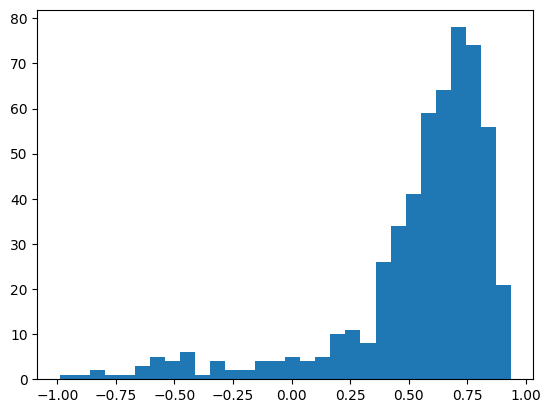

In [ ]:
import matplotlib.pyplot as plt

plt.hist(test_scores[test_scores>-1], bins=30)

In [ ]:
test_scores[~np.isnan(test_scores)].__len__(), np.mean(test_scores[~np.isnan(test_scores)]), np.median(test_scores[~np.isnan(test_scores)])

(559, 0.22202271687383954, 0.6301418296276005)

## TSNE

In [23]:
embedding_matrix = catchment_embeddings.detach().to("cpu").numpy()

In [24]:
from sklearn.manifold import TSNE

In [25]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=20,n_iter=5000).fit_transform(embedding_matrix)

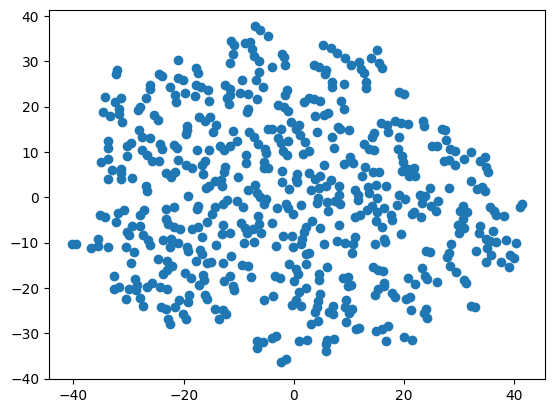

In [26]:
import matplotlib.pyplot as plt

plt.plot(X_embedded[:,0],X_embedded[:,1], "o")

In [27]:
import matplotlib.pyplot as plt

plt.plot(test_metrics.detach().to("cpu").numpy()[999,:])

NameError: name 'test_metrics' is not defined

In [48]:
y_reshape = y.swapaxes(0,1).reshape(2055,-1)

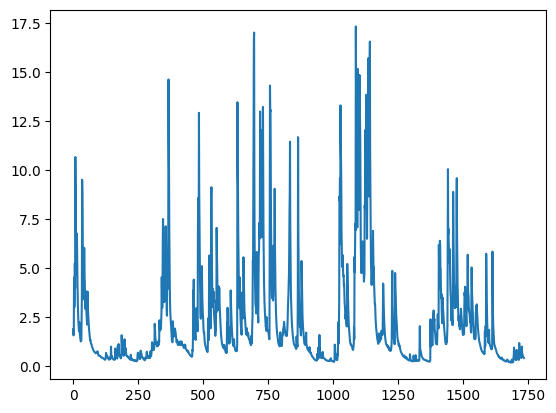

In [56]:
plt.plot(y_reshape.detach().to("cpu").numpy()[1000,:])